# Micromodel Properties
---
This example notebook will show some of the structure properties of a generated network in comparison to XCT image data. This will include caluclating porosity and finding feret diameters.

In [10]:
from pore2chip import metrics, filter_im
import cv2 as cv
import os
import copy
import numpy as np
import math
from matplotlib import pyplot as plt

# PoreSpy for porosity analysis
import porespy as ps
import openpnm as op

# Skimake.measure for feret angle visualization
from skimage.measure import label, regionprops

path = os.getcwd()

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading XCT (for comparison)
---

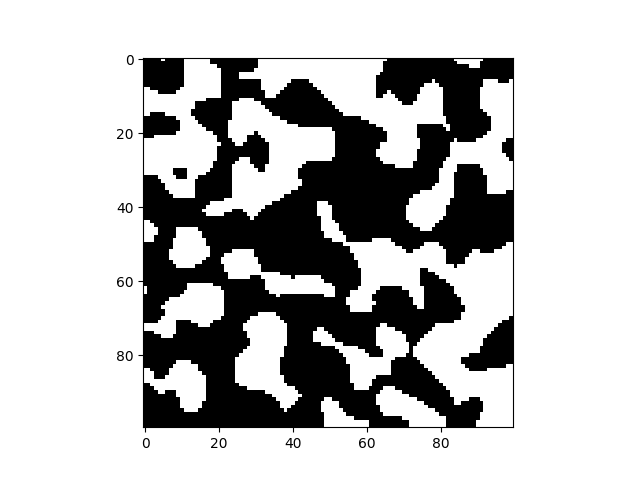

In [7]:
image_path = r'bean_bucket_100/'
filtered_images = filter_im.read_and_filter_list(image_path, [0, 100], [0, 100], 100, invert=True)

fig, ax = plt.subplots()
ax.imshow(filtered_images[1,:,:], cmap='gray')

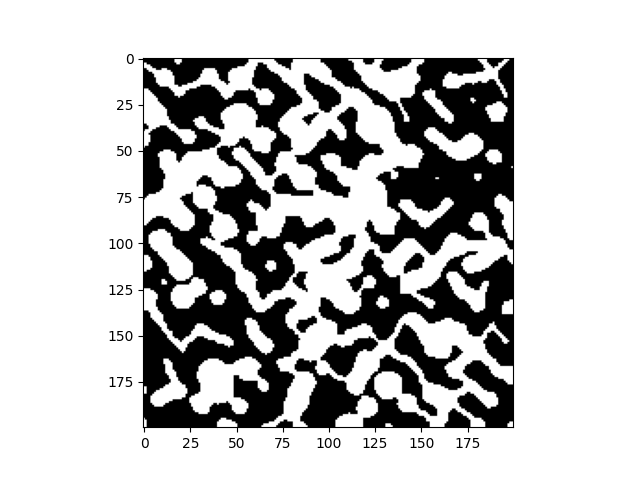

In [3]:
model_path = os.path.dirname(path) + r'\example_outputs\\network1.png'
micromodel = cv.imread(model_path, 0)
micromodel_filtered = filter_im.filter_single(micromodel, invert=True)
fig, ax = plt.subplots()
ax.imshow(micromodel_filtered, cmap='gray')

## Porosity
---
Porosity is easily calculated using PoreSpy. NOTE: PoreSpy counts non-zero values( in our case, white pixels) as pores. Pore2Chip generates an image where black pixels are pores. That is why we set ```invert=True``` when filtering the image.

In [8]:
porosity1 = ps.metrics.porosity(micromodel_filtered / micromodel_filtered.max())
porosity2 = ps.metrics.porosity(filtered_images / filtered_images.max())
print("Micromodel Porosity:", porosity1 * 100.0, "%")
print("XCT Porosity:", porosity2 * 100.0, "%")

Micromodel Porosity: 46.0675 %
XCT Porosity: 43.067 %


## Feret Diameters
---
We can calculate feret diameters and their distributions using ```metrics.feret_diameters```. If there are no disconnected pore clusters, then the algorithm will calculate the feret diameter using a convex hull of the entire pore shape (all of this is done with the help of ```skimage``` and the ```feret``` library).

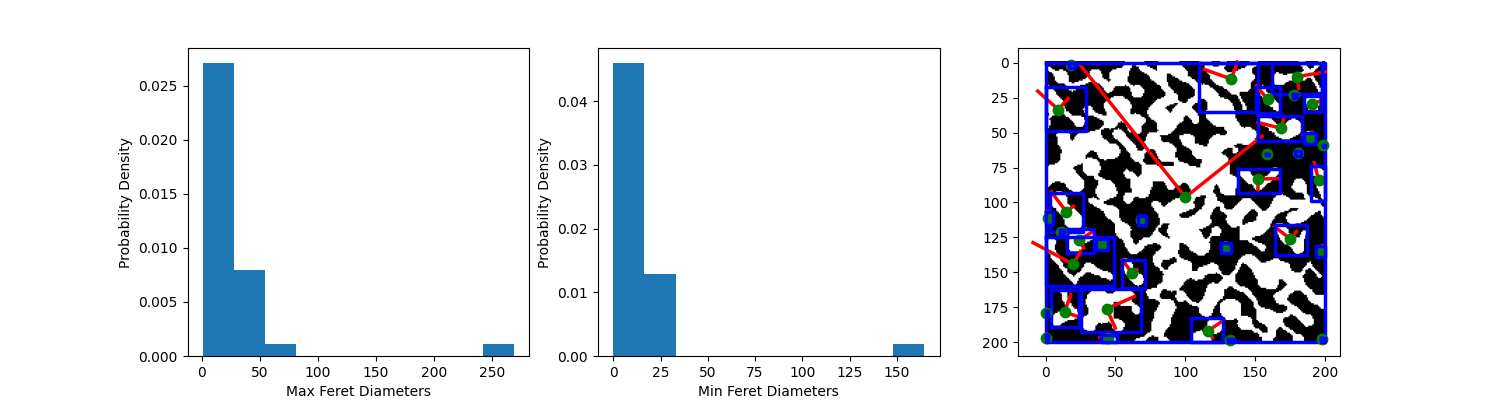

In [11]:
max_feret, min_feret = metrics.feret_diameter(micromodel_filtered)

fig, ax = plt.subplots(1, 3, figsize=[15, 4])
ax[0].hist(max_feret, density = True)
ax[1].hist(min_feret, density = True)
ax[0].set_xlabel("Max Feret Diameters")
ax[1].set_xlabel("Min Feret Diameters")
ax[0].set_ylabel("Probability Density")
ax[1].set_ylabel("Probability Density")

ax[2].imshow(micromodel_filtered, cmap=plt.cm.gray)
label_img = label(micromodel_filtered)
regions = regionprops(label_img)
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax[2].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax[2].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax[2].plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[2].plot(bx, by, '-b', linewidth=2.5)

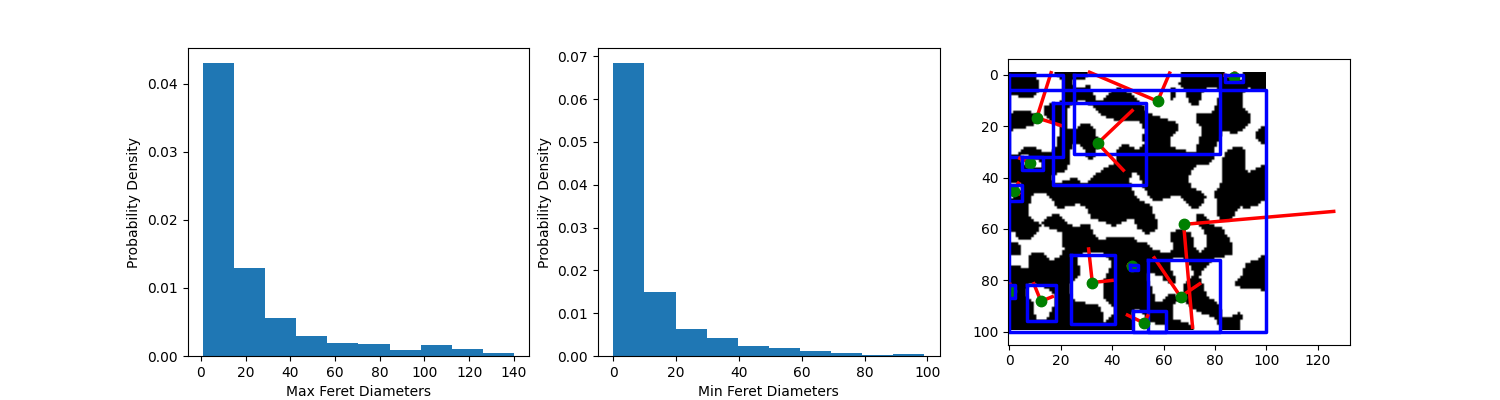

In [12]:

max_feret, min_feret = metrics.feret_diameter_list(filtered_images)

fig, ax = plt.subplots(1, 3, figsize=[15, 4])
ax[0].hist(max_feret, density = True)
ax[1].hist(min_feret, density = True)
ax[0].set_xlabel("Max Feret Diameters")
ax[1].set_xlabel("Min Feret Diameters")
ax[0].set_ylabel("Probability Density")
ax[1].set_ylabel("Probability Density")

ax[2].imshow(filtered_images[0,:,:], cmap=plt.cm.gray)
label_img = label(filtered_images[0,:,:])
regions = regionprops(label_img)
for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax[2].plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax[2].plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax[2].plot(x0, y0, '.g', markersize=15)

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[2].plot(bx, by, '-b', linewidth=2.5)

## SNOW Regions and Network Extraction on Micromodel
---
Here, we use the SNOW algorithm provided by PoreSpy to show the pore regions of the micromodel and extract a network from it.

0it [00:00, ?it/s]

(-0.5, 199.5, -0.5, 199.5)

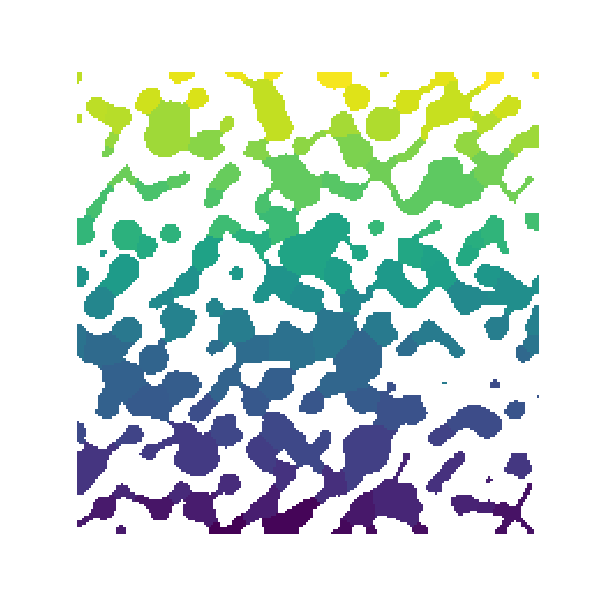

In [4]:
snow = ps.filters.snow_partitioning(micromodel_filtered)
regions = snow.regions
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.imshow(regions/micromodel_filtered, origin='lower', interpolation='none')
ax.axis(False)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/191 [00:00<?, ?it/s]

(-0.5, 214.225, -3.7065158549257546, 217.43151585492575)

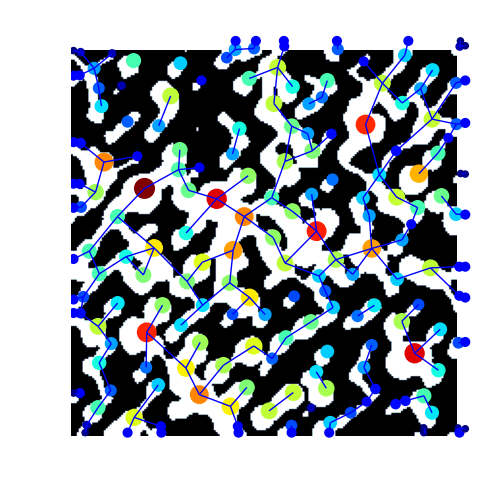

In [5]:
sn = ps.networks.snow2(micromodel_filtered, voxel_size=1)
extract = op.io.network_from_porespy(sn.network)
fig, ax = plt.subplots(figsize=[5, 5])
ax.imshow(micromodel_filtered.T, cmap=plt.cm.bone)
op.visualization.plot_coordinates(ax=fig,
                                  network=extract,
                                  size_by=extract["pore.inscribed_diameter"],
                                  color_by=extract["pore.inscribed_diameter"],
                                  markersize=200)
op.visualization.plot_connections(network=extract, ax=fig)
ax.axis("off")